In [1]:
from numba import cuda
import matplotlib.pyplot as plt
from numba import njit, jit
import numpy as np

In [2]:
FONT_SIZE = 18

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=FONT_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title

In [3]:
B_INC = 0.0000000001

In [4]:
def show_grid(grid, d3 = False, slises=False):
    ''' 
    Show grid in different formats 
    by default shows projection of sums by axes 
    '''
    L = grid.shape
    
    ''' Show 3D plot '''
    if d3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        # ax.grid(False)
        # ax.set_axis_off()
        colors = {0:'b', 1:'r'}
        for i in range(L[0]):
            for j in range(L[1]):
                for k in range(L[2]):
                    ax.scatter(i, j, k, c=colors[grid[i,j,k]], s=5) # s=np.sqrt(((i+1)**2 + (k + 1)**2 + (L-j)**2)/3) show depth through size

        plt.show()

    ''' supporting lines '''            
    # for i in range(L):
    #     for j in range(L):
    #         ax.plot([i,i], [j,j], [0, L - 1], c='0.5', linewidth=0.5)
    #         ax.plot([0, L - 1], [j,j], [i,i], c='0.5', linewidth=0.5)
    #         ax.plot([j,j], [0, L - 1], [i,i], c='0.5', linewidth=0.5)
    
    ''' Show slices '''
    if slises:
        rows = L
        columns = 3
        fig = plt.figure()
        for i in range(L):
            fig.add_subplot(rows, columns, i*3 + 1)
            plt.imshow(grid[i,:,:], cmap=plt.get_cmap('Paired'))
            fig.add_subplot(rows, columns, i*3 + 2)
            plt.imshow(grid[:,i,:], cmap=plt.get_cmap('Paired'))
            fig.add_subplot(rows, columns, i*3 + 3)
            plt.imshow(grid[:,:,i], cmap=plt.get_cmap('Paired'))
        plt.show()

    ''' Shows projection of sums by axes '''
    rows = 1
    columns = 3
    fig = plt.figure()
    Px = np.zeros((L[1], L[2]), dtype=int)
    Py = np.zeros((L[0], L[2]), dtype=int)
    Pz = np.zeros((L[0], L[1]), dtype=int)
    for i in range(L[0]):
        Px += grid[i, :, :]
    for i in range(L[1]):
        Py += grid[:, i, :]
    for i in range(L[2]):
        Pz += grid[:, :, i]
    Px = Px / L[0]
    Py = Py / L[1]
    Pz = Pz / L[2]
    fig.add_subplot(rows, columns, 1)
    plt.imshow(Px)
    fig.add_subplot(rows, columns, 2)
    plt.imshow(Py)
    fig.add_subplot(rows, columns, 3)
    plt.imshow(Pz)
    plt.show()
#     TODO: fix slices

In [5]:
NUM_NEIGHB = 27

def get_site(coord, L):
    """Get the site index from the 3-vector of coordinates."""
    # XXX: 3D hardcoded, can do N-D
    return coord[0] * L[1] * L[2] + coord[1] * L[2] + coord[2]


def get_coord(site, L):
    """Get the 3-vector of coordinates from the site index."""
    # XXX: 3D hardcoded, can do N-D
    x = site // (L[1]*L[2])
    yz = site % (L[1]*L[2])
    y = yz // L[2]
    z = yz % L[2]
    return [x, y, z]


def get_neighbors(site, L):
    neighb = set()
    x, y, z = get_coord(site, L)
    for i in [-1, 0, 1]:
        for j in [-1, 0, 1]:
            for k in [-1, 0, 1]:
                x1 = (x + i) % L[0]
                y1 = (y + j) % L[1]
                z1 = (z + k) % L[2]
                neighb.add(get_site([x1, y1, z1], L))
    
    return list(neighb)
    
def tabulate_neighbors(L):
    """Tabulate the root-2 neighbors on the 3D cubic lattice with PBC."""
    Nsite = L[0]*L[1]*L[2]
    neighb = np.empty((Nsite, NUM_NEIGHB), dtype=int)
    for site in range(Nsite):
        neighb[site, :] = get_neighbors(site, L)
    return neighb



def tabulate_neighbors_small_L(L):
    """
    Tabulate the root-2 neighbors on the 3D cubic lattice with PBC.
    Must be used when L[0], L[1] or L[2] < 3 
    """
    Nsite = L[0]*L[1]*L[2]
    neighb = [[]] * Nsite
    for site in range(Nsite):
        neighb[site] = get_neighbors(site, L)
    return neighb

Cuda jited functions 

In [6]:
@cuda.jit
def culc_scores(grid, neighbors, scores, b):
    site = cuda.grid(1)
    if site < grid.size:
        for site1 in neighbors[site]:
            scores[site] += (1 - grid[site1])

        if grid[site] == 1:
            scores[site] *= b
            
@cuda.jit
def new_stratagies(grid, current, neighbors, scores, b):
    site = cuda.grid(1)
    if site < grid.size:
        best_site = site
        for site1 in neighbors[site]:
            if (scores[best_site] < scores[site1]):
                best_site = site1

        grid[site] = current[best_site]

@cuda.jit
def make_zeros(to_zeros):
    pos = cuda.grid(1)
    if pos < to_zeros.size:
        to_zeros[pos] = 0
        
        
@cuda.jit
def copy_ar(a, b):
    pos = cuda.grid(1)
    if pos < a.size:
        a[pos] = b[pos]

## Numba Cuda jit evolution function

In [7]:
def evolve3D_4(grid, neighbors, b, num_steps):
    L = grid.shape
    grid = grid.flatten().astype(int)
    SIZE = len(grid)
    _zeros = np.zeros((SIZE), dtype=float)
    _int_zeros = np.zeros((SIZE), dtype=int)
    
    ''' threads and blocks for cuda computation'''
    threadsperblock = 32
    blockspergrid = (grid.size + (threadsperblock - 1)) // threadsperblock
    
    
    ''' allocate global arrays '''
    current = cuda.to_device(_int_zeros)
    scores = cuda.to_device(_zeros)
    grid_global = cuda.to_device(grid)
    
    for step in range(num_steps):
        copy_ar[blockspergrid, threadsperblock](current, grid_global)
        make_zeros[blockspergrid, threadsperblock](scores)
        
        culc_scores[blockspergrid, threadsperblock](grid_global, neighbors, scores, b)
                
        new_stratagies[blockspergrid, threadsperblock](grid_global, current, neighbors, scores, b)
    grid = grid_global.copy_to_host()
    return np.reshape(grid, L)

In [8]:
import timeit
rndm = np.random.RandomState(12345)
N = 1
Size = 60
L = (Size, Size, Size)
print(L)
neighbors = tabulate_neighbors(L)
field = (rndm.uniform(size=L) > 0.9)
field = evolve3D_4(field, neighbors, 1.3, num_steps=N)

(60, 60, 60)


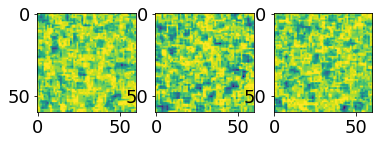

In [9]:
field = evolve3D_4(field, neighbors, 1.3, num_steps=1)
show_grid(field)

Numba jit for comparison

In [10]:
def evolve3D_3(grid, neighbors, b, num_steps=1):
    L = grid.shape
    grid = grid.flatten().astype(int)
    SIZE = len(grid)
    _zeros = np.zeros((SIZE), dtype=float)
    _int_zeros = np.zeros((SIZE), dtype=int)
    evolve3D_impl(grid, neighbors, b, num_steps, _zeros, _int_zeros)
    
    return np.reshape(grid, L)

@njit
def evolve3D_impl(grid, neighbors, b, num_steps, _zeros, _int_zeros):
    
    SIZE = len(grid)
    current = _int_zeros.copy()
    scores = _zeros.copy()
    for step in range(num_steps):
        current = grid.copy()
        scores = _zeros.copy()
        for site in range(SIZE):
            for site1 in neighbors[site]:
                scores[site] += (1 - grid[site1])
                
            if grid[site] == 1:
                scores[site] *= b
                
        for site in range(SIZE):
            best_site = site
            for site1 in neighbors[site]:
                if (scores[best_site] < scores[site1]):
                    best_site = site1
                    
            grid[site] = current[best_site]
    return grid

In [11]:
from numpy.testing import assert_equal
# check that the dynamics are identical
L = (20, 20, 20)

neighbors = tabulate_neighbors(L)

rndm = np.random.RandomState(12345)

B = set()
for i in range(28):
    for j in range(1, 28):
        if i/j > 1 and i / j < 2:
            B.add((i/j) + B_INC)
B = sorted(list(B))

N = 5

for i in range(0, len(B), len(B)//10):
    b = B[i]
    field = (rndm.uniform(size=L) > 0.5).astype(int)
    field2 = field.copy()
    field = evolve3D_4(field.copy(), neighbors, b, num_steps=N)
    field2 = evolve3D_3(field2.copy(), neighbors, b, num_steps=N)
    assert_equal(field, field2)
    print('Game stabilized:', field.all())

Game stabilized: False
Game stabilized: False
Game stabilized: False
Game stabilized: False
Game stabilized: False
Game stabilized: True
Game stabilized: True
Game stabilized: True
Game stabilized: True
Game stabilized: True
Game stabilized: True


Cython function for time comparison

In [12]:
%load_ext cython

In [13]:
%%cython -a

import numpy as np

import cython

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def evolve3D_2_C(grid_orig, long[:, :] neighbors, double b, int num_steps=1):
    
    cdef int N_NEIGHB = 27 
    L = grid_orig.shape
    cdef short[:] grid = grid_orig.flatten()
    
    cdef int SIZE, step, site, site1, best_site, i
    SIZE = L[0] * L[1] * L[2]
    cdef short[:] current = grid.copy()
    cdef double[:] _zeros = np.zeros((SIZE), dtype=float)
    cdef double[:] scores = np.zeros((SIZE), dtype=float)
    
    for step in range(num_steps):
        current = grid.copy()
        scores[...] = _zeros
        for site in range(SIZE):
            for i in range(N_NEIGHB):
                site1 = neighbors[site,i]
                scores[site] += (1 - grid[site1])
                
            if grid[site] == 1:
                scores[site] *= b
        
        for site in range(SIZE):
            best_site = site
            for i in range(N_NEIGHB):
                site1 = neighbors[site,i]
                if (scores[best_site] < scores[site1]):
                    best_site = site1
                    
            grid[site] = current[best_site]
    grid_orig = np.array(grid)
    return np.reshape(grid_orig, L)

In [14]:
import timeit
rndm = np.random.RandomState(12345)
N = 1
Size = 60
L = (Size, Size, Size)
print(L)
neighbors = tabulate_neighbors(L)
field = (rndm.uniform(size=L) > 0.5).astype('int16')
field = evolve3D_2_C(field, neighbors, 1.3, num_steps=N)
field = evolve3D_3(field, neighbors, 1.3, num_steps=N)
field = evolve3D_4(field, neighbors, 1.3, num_steps=N)

(60, 60, 60)


In [15]:
%timeit evolve3D_2_C(field.astype('int16'), neighbors, 1.3, num_steps=N)

59.7 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [16]:
%timeit evolve3D_3(field, neighbors, 1.3, num_steps=N)

43.7 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%timeit evolve3D_4(field, neighbors, 1.3, num_steps=N)

101 ms ± 2.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
import timeit

In [19]:
# have to run numba functions above before measuring time to compile numba code
rndm = np.random.RandomState(12345)
N = 1
N_repeats = 3
times = list()
times_4 = list()
times_C = list()
for size in range(10, 80, 10):
    L = (size, size, size)
    print(L)
    neighbors = tabulate_neighbors(L)
    field = (rndm.uniform(size=L) > 0.5).astype('int16')
    times_C.append(timeit.timeit('evolve3D_2_C(field, neighbors, 1.3, num_steps=N)', number=N_repeats, globals=globals()) / N_repeats)
    times.append(timeit.timeit('evolve3D_3(field, neighbors, 1.3, num_steps=N)', number=N_repeats, globals=globals()) / N_repeats)
    times_4.append(timeit.timeit('evolve3D_4(field, neighbors, 1.3, num_steps=N)', number=N_repeats, globals=globals()) / N_repeats)
    
    print(times_C[-1])
    print(times[-1])
    print(times_4[-1])

(10, 10, 10)
0.00039656666666587626
0.0003707666666628029
0.011816033333332143
(20, 20, 20)
0.002928900000000567
0.0016827000000034786
0.010536533333331969
(30, 30, 30)
0.006901833333330387
0.005591066666662907
0.019354733333329932
(40, 40, 40)
0.015517600000000206
0.013631399999998925
0.03865739999999581
(50, 50, 50)
0.037759833333334804
0.031545966666669756
0.06357723333333827
(60, 60, 60)
0.055540600000000495
0.063972400000002
0.10233526666666155
(70, 70, 70)
0.09536879999999807
0.08168889999999844
0.18067246666666392


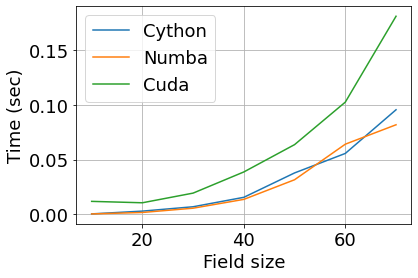

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Field size')
ax.set_ylabel('Time (sec)')
ax.plot([10, 20, 30, 40, 50, 60, 70], times_C, label = "Cython")
ax.plot([10, 20, 30, 40, 50, 60, 70], times, label = "Numba")
ax.plot([10, 20, 30, 40, 50, 60, 70], times_4, label = "Cuda")
plt.grid(True)
plt.legend(loc = 'best')
plt.show()